In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
import warnings
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import svm
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import optuna
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA


## Read Test data

In [2]:
test_home_team_statistics_df = pd.read_csv('test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('test_away_team_statistics_df.csv', index_col=0)
test_home_player_statistics_df = pd.read_csv('test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv('test_away_player_statistics_df.csv', index_col=0)

train_home_team_statistics_df = pd.read_csv('train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('train_away_team_statistics_df.csv', index_col=0)
train_home_player_statistics_df = pd.read_csv('train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('train_away_player_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('Y_train.csv', index_col=0)

In [20]:
test_home = test_home_team_statistics_df.iloc[:,:]
test_away = test_away_team_statistics_df.iloc[:,:]
diff_test = test_home - test_away
test_home.columns = test_home.columns + '_home'
test_away.columns = test_away.columns + '_away'
diff_test.columns = diff_test.columns + '_diff'

# impute missing values
test_data = pd.concat([test_home, test_away, diff_test], axis=1,)
mean_values = test_data.mean()
test_data = test_data.fillna(mean_values)

# scale the data 
scaler = StandardScaler()
test_data = pd.DataFrame(scaler.fit_transform(test_data), columns=test_data.columns)





/Users/marama/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/marama/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/marama/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


## Read Train data

In [21]:
train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]
diff_train = train_home - train_away

In [14]:

train_home.columns = train_home.columns + '_home'
train_away.columns = train_away.columns + '_away'
diff_train.columns = diff_train.columns + '_diff'



# inpute missing values
train_data = pd.concat([train_home, train_away,diff_train], axis=1)
mean_values = train_data.mean()
train_data = train_data.fillna(mean_values)


# scale the data
scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)

def func(row):
    if row[0]==1:
        return "HOME_WINS"
    elif row[1]==1:
        return "DRAW"
    elif row[2]==1:
        return "AWAY_WINS"

train_scores['result'] = train_scores.apply(func,axis=1)
train_scores = train_scores['result']

train_scores

ID
0        AWAY_WINS
1             DRAW
2        AWAY_WINS
3        HOME_WINS
4             DRAW
           ...    
12298    AWAY_WINS
12299    AWAY_WINS
12300    AWAY_WINS
12301    HOME_WINS
12302    HOME_WINS
Name: result, Length: 12303, dtype: object

### train, valid  split

In [15]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(train_data, train_scores, train_size=0.8, random_state=43)


In [17]:
# set a random forest
clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001)
clf.fit(X_train, y_train)

# predict the validation set
y_pred = clf.predict(X_val)

# print the accuracy
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Confusion Matrix:', confusion_matrix(y_val, y_pred))

Accuracy: 0.49695245835026414
Confusion Matrix: [[340   1 417]
 [167   1 452]
 [201   0 882]]


In [18]:
# predict on the test data

y_submit = clf.predict(test_data)
y_submit = pd.DataFrame(y_submit)

y_submit.index = y_submit.index + 12303
y_submit.columns = ['result']
y_submit['HOME_WINS'] = y_submit['result'].apply(lambda x : 1 if x == 'HOME_WINS' else 0)
y_submit['DRAW'] = y_submit['result'].apply(lambda x : 1 if x == 'DRAW' else 0)
y_submit['AWAY_WINS'] = y_submit['result'].apply(lambda x : 1 if x == 'AWAY_WINS' else 0)
y_submit = y_submit.drop('result',axis=1)
y_submit.to_csv('submission.csv')


# Predict draws 

In [9]:
# upsampling of draws and away wins
X_train_not_draw = train[train[0] != 'DRAW']
X_train_draw = train[train[0] == 'DRAW']


train_data_draw_upsampled = resample(X_train_draw, replace=True, n_samples=len(X_train_not_draw), random_state=42)

train_data_upsampled = pd.concat([X_train_not_draw, train_data_draw_upsampled])

X_train_upsampled = train_data_upsampled.iloc[:,:-1]
y_train_upsampled = train_data_upsampled.iloc[:,-1]

In [10]:
# create a predictor if its a draw or not

y_train_d = y_train_upsampled.apply(lambda x: 1 if x == "DRAW" else 0)
y_val_d = y_val.apply(lambda x: 1 if x == "DRAW" else 0)


# create a predictor if the home team wins or not
clf = SVC(kernel='rbf', probability=True)
clf.fit(X_train_upsampled, y_train_d)


y_pred_d = clf.predict(X_val)
print("roc_auc_score: ", roc_auc_score(y_val_d, y_pred_d))


In [14]:
# print the confusion matrix

print("Confusion Matrix: \n", confusion_matrix(y_val_d, y_pred_d))
print("accuracy_score: ", accuracy_score(y_val_d, y_pred_d))

Confusion Matrix: 
 [[1109  732]
 [ 376  244]]
accuracy_score:  0.5497765136123527


In [15]:
# select the important features

important_features = pd.Series(clf.feature_importances_, index=X_train_upsampled.columns).sort_values(ascending=False)
important_features = important_features[important_features > 0]
important_features

TEAM_YELLOWCARDS_5_last_match_std        0.017016
TEAM_CORNERS_5_last_match_std            0.016746
TEAM_SHOTS_ON_TARGET_5_last_match_std    0.015353
TEAM_INJURIES_5_last_match_sum           0.014815
TEAM_BALL_POSSESSION_5_last_match_std    0.013309
                                           ...   
TEAM_YELLOWCARDS_season_sum              0.001048
TEAM_SHOTS_TOTAL_5_last_match_std        0.001027
TEAM_CORNERS_season_average              0.001013
TEAM_YELLOWCARDS_season_average          0.000928
TEAM_OFFSIDES_5_last_match_std           0.000245
Length: 219, dtype: float64

## Hyperparameters of RF

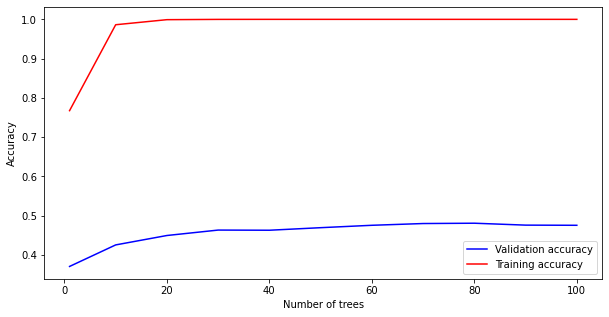

In [83]:
# evaluate the impact of the number of trees in the forest on the performance of the model

n_estimators = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
val_results = []
train_results = []
for estimator in n_estimators:
    rf_clf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1, random_state=42)
    rf_clf.fit(X_train, y_train)
    train_pred = rf_clf.predict(X_train)
    val_pred = rf_clf.predict(X_val)
    train_accuracy = accuracy_score(y_train, train_pred)
    val_accuracy = accuracy_score(y_val, val_pred)
    val_results.append(val_accuracy)
    train_results.append(train_accuracy)

plt.figure(figsize=(10,5))
plt.plot(n_estimators, val_results, 'b', label='Validation accuracy')
plt.plot(n_estimators, train_results, 'r', label='Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.legend()
plt.show()


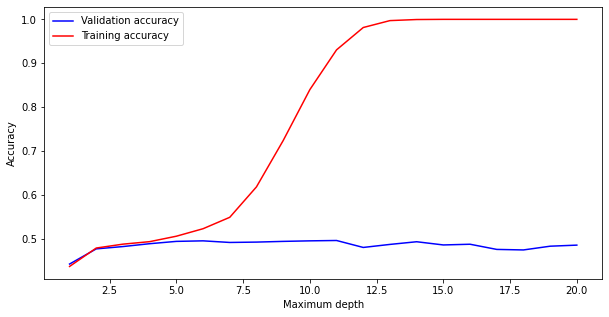

In [85]:
# evaluate the impact of the maximum depth of the trees in the forest on the performance of the model

max_depths = [i for i in range(1, 21)]
val_results = []
train_results = []
for depth in max_depths:
    rf_clf = RandomForestClassifier(max_depth=depth, n_jobs=-1, random_state=42)
    rf_clf.fit(X_train, y_train)
    train_pred = rf_clf.predict(X_train)
    val_pred = rf_clf.predict(X_val)
    train_accuracy = accuracy_score(y_train, train_pred)
    val_accuracy = accuracy_score(y_val, val_pred)
    val_results.append(val_accuracy)
    train_results.append(train_accuracy)

plt.figure(figsize=(10,5))
plt.plot(max_depths, val_results, 'b', label='Validation accuracy')
plt.plot(max_depths, train_results, 'r', label='Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Maximum depth')
plt.legend()
plt.show()

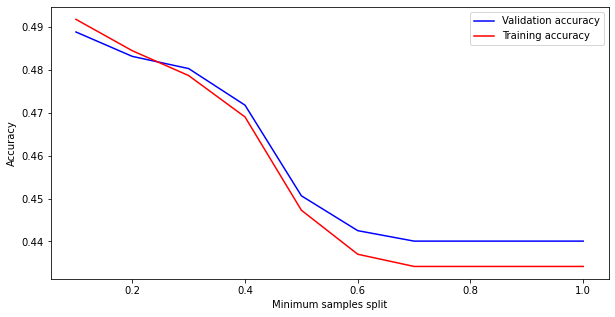

In [87]:
# evaluate the impact of the minimum number of samples required to split an internal node on the performance of the model

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
val_results = []
train_results = []
for min in min_samples_splits:
    rf_clf = RandomForestClassifier(min_samples_split=min, n_jobs=-1, random_state=42)
    rf_clf.fit(X_train, y_train)
    train_pred = rf_clf.predict(X_train)
    val_pred = rf_clf.predict(X_val)
    train_accuracy = accuracy_score(y_train, train_pred)
    val_accuracy = accuracy_score(y_val, val_pred)
    val_results.append(val_accuracy)
    train_results.append(train_accuracy)

plt.figure(figsize=(10,5))
plt.plot(min_samples_splits, val_results, 'b', label='Validation accuracy')
plt.plot(min_samples_splits, train_results, 'r', label='Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Minimum samples split')
plt.legend()
plt.show()


In [ ]:
# predict on the test data

y_submit = rf_clf.predict(test_data)
y_submit = pd.DataFrame(y_submit)

y_submit.index = y_submit.index + 12303
y_submit.columns = ['result']
y_submit['HOME_WINS'] = y_submit['result'].apply(lambda x : 1 if x == 'HOME_WINS' else 0)
y_submit['DRAW'] = y_submit['result'].apply(lambda x : 1 if x == 'DRAW' else 0)
y_submit['AWAY_WINS'] = y_submit['result'].apply(lambda x : 1 if x == 'AWAY_WINS' else 0)
y_submit = y_submit.drop('result',axis=1)
y_submit.to_csv('submission.csv')

